In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.integrate import quad

from time import perf_counter as time

from tqdm import tqdm
from scipy import linalg, stats

from scipy.special import jacobi, legendre, roots_jacobi, eval_jacobi, factorial, gamma

from tb_utils import JacobiGL, constructV, constructVx, constructD, z2x, z2x_dz, x2z, x2z_dx, evaluate_jacobi_grid, constructMinv

# import warnings
# warnings.filterwarnings('ignore')

## 2a) - simple BVP

In [2]:
eps = 0.1
x0, xN = 0, 1
g0, gN = 0, 0
a_pde, b_pde, c_pde = -eps, -1, 0

# def f(x): return np.zeros(x.shape[0])
def f(x): return np.ones(x.shape[0])

def u_exact_solution(x, eps=eps): return (np.exp(-x/eps) + (x - 1) - np.exp(-1/eps)*x)/(np.exp(-1/eps) - 1)

### Collocation - LCM (nodal)

In [3]:
# def constructV(z: np.ndarray, alpha=0, beta=0, a = -1, b = 1):
#     "Function for constructing the Vandermonde matrix, V_{ij} = P_j(x_i)"
#     N = z.shape[0]
#     V = np.zeros((N, N))
#     for n in range(N):
#         V[n, :] = eval_jacobi(n, alpha, beta, z)
#     # V = np.sqrt(2 / (b - a)) * V
#     # V = V * np.sqrt((2*np.arange(1,N+1))/(b - a))
#     return V.T


# def constructVx(z: np.ndarray, alpha=0, beta=0, a = -1, b = 1):
#     "Function for constructing the derivative of Vandermonde matrix, Vx = dV/dx; chain rule applied"
#     N = z.shape[0]
#     Vx = np.zeros((N, N))
#     for n in range(1, N):
#         Vx[n, :] = ((n + alpha + beta + 1)/2) * eval_jacobi(n-1, alpha+1, beta+1, z)
#     Vx = 2 / (b - a) * Vx
#     return Vx.T


# def constructD(z: np.ndarray, alpha = 0, beta = 0, a = -1, b = 1, V = None, Vx = None):
#     "Function for constructing the differentiation matrix D = Vx V^{-1}"
#     if V is None:
#         V = constructV(z=z, alpha=alpha, beta=beta, a=a, b=b)
#     if Vx is None:
#         Vx = constructVx(z=z, alpha=alpha, beta=beta, a=a, b=b)
#     # solve D = Vx V^{-1} <=> D V = Vx <=> V.T D.T = Vx.T <=> D.T = solve(V.T, Vx.T) <=> D = solve(V.T, Vx.T).T
#     D = linalg.solve(V.T, Vx.T).T
#     return D


# def jacobi_p_normalisation_const(alpha: float, beta: float, n: int):
#     "Author: Jeppe"
#     return (
#         2 ** (alpha + beta + 1)
#         * (gamma(n + alpha + 1) * gamma(n + beta + 1))
#         / (factorial(n) * (2 * n + alpha + beta + 1) * gamma(n + alpha + beta + 1))
#     )


# def constructMinv(z = None, V = None, alpha=0, beta=0, a = -1, b = 1):
#     "Function for constructing the mass matrix inverse M^{-1}"
#     if V is None:
#         V = constructV(z=z, alpha=alpha, beta=beta, a=a, b=b)
#     N = V.shape[0]
#     norm_const = jacobi_p_normalisation_const(alpha, beta, np.arange(N))
#     V_normalized = V / np.sqrt(norm_const)
#     M_inv = V_normalized @ V_normalized.T
#     return M_inv

In [10]:
alpha, beta = 0, 0 # Legendere polynomials
N = 10

# z are the points in [-1,1]
z = JacobiGL(alpha=alpha, beta=beta, N=N)
D = constructD(z=z, alpha=alpha, beta=beta, a=x0, b=xN)

x = z2x(z=z, a=x0, b=xN)

# du/dz = D u => du/dx dx/dz = D u => du/dx = (1 / (dx/dz)) D u
# x2z_dz_value = x2z_dx(x0, xN)
# D = x2z_dz_value * D_z

# in the slides there is a mistake, a is correct, -a is NOT correct
L_N = a_pde * D @ D + b_pde * D + c_pde * np.eye(N+1)

L_N[0, :] = 0
L_N[0, 0] = 1

L_N[N, :] = 0
L_N[N, N] = 1

print(f"{L_N.shape = }")
print(f"{np.linalg.cond(L_N) = }")
# plt.spy(L_N)

fx = f(x).copy()
fx[0] = g0
fx[N] = gN

# in nodal space
u = linalg.solve(L_N, fx)

V = constructV(z=z, alpha=alpha, beta=beta)
# V = ((xN-x0)/2) * V ## not needed
u_hat = linalg.solve(V, u)

M_inv = constructMinv(z=z, V=V, alpha=alpha, beta=beta, a=-1, b=1)

error = u - u_exact_solution(x=x)
e_l2_2 = error @ linalg.solve(M_inv, error)

x_eval = np.linspace(x0, xN, 200)
A = evaluate_jacobi_grid(x_eval, x, x0, xN, alpha=alpha, beta=beta)
u_eval = A @ u_hat

L_N.shape = (11, 11)
np.linalg.cond(L_N) = np.float64(447.62970984076054)


/Users/tymoteuszbarcinski/DTU/2_autum_2025/02689/02689-Advanced-Numerical-Methods/assignment_2/tb_utils.py:117: RuntimeWarning: divide by zero encountered in matmul
  M_inv = V_normalized @ V_normalized.T
/Users/tymoteuszbarcinski/DTU/2_autum_2025/02689/02689-Advanced-Numerical-Methods/assignment_2/tb_utils.py:117: RuntimeWarning: overflow encountered in matmul
  M_inv = V_normalized @ V_normalized.T
/Users/tymoteuszbarcinski/DTU/2_autum_2025/02689/02689-Advanced-Numerical-Methods/assignment_2/tb_utils.py:117: RuntimeWarning: invalid value encountered in matmul
  M_inv = V_normalized @ V_normalized.T


TypeError: evaluate_jacobi_grid() got multiple values for argument 'alpha'

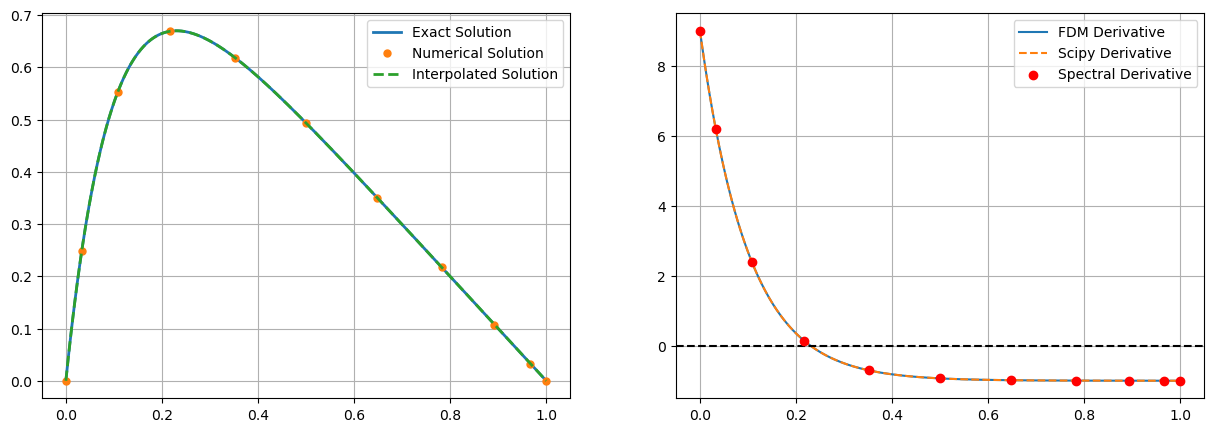

In [9]:
x_plot = np.linspace(x0, xN, 500)
u_exact_plot = u_exact_solution(x_plot, eps)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(x_plot, u_exact_plot, label="Exact Solution", linewidth=2)
ax[0].plot(x, u, 'o', label="Numerical Solution", markersize=5)
ax[0].plot(x_eval, u_eval, '--', label="Interpolated Solution", linewidth=2)
ax[0].grid();
ax[0].legend();


h = np.median(np.diff(x_plot))
du_dx_fdm = (u_exact_plot[2:] - u_exact_plot[:-2])/(2*h)

from scipy.differentiate import derivative
res = derivative(u_exact_solution, x_plot)

du_dx_spectral = D @ u_exact_solution(x, eps)

ax[1].plot(x_plot[1:-1], du_dx_fdm, label="FDM Derivative");
ax[1].plot(x_plot, res.df, linestyle='--', label = "Scipy Derivative");
ax[1].scatter(x, du_dx_spectral, color='red', label="Spectral Derivative", zorder=5)
ax[1].axhline(0, color='k', linestyle='--')
ax[1].legend();
ax[1].grid();

/opt/anaconda3/envs/scicom/lib/python3.12/site-packages/scipy/differentiate/_differentiate.py:537: RuntimeWarning: divide by zero encountered in matmul
  work.df[ic] = fc @ wc / work.h[ic]
/opt/anaconda3/envs/scicom/lib/python3.12/site-packages/scipy/differentiate/_differentiate.py:537: RuntimeWarning: overflow encountered in matmul
  work.df[ic] = fc @ wc / work.h[ic]
/opt/anaconda3/envs/scicom/lib/python3.12/site-packages/scipy/differentiate/_differentiate.py:537: RuntimeWarning: invalid value encountered in matmul
  work.df[ic] = fc @ wc / work.h[ic]


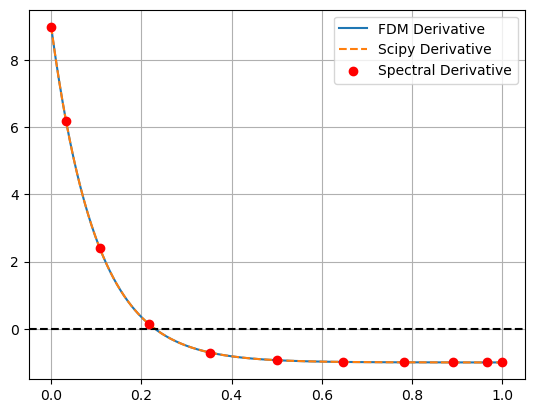

### Tau - LTM (modal)

## 2b) - complex BVP, flow cylinder